In [1]:
!pip install torch

In [36]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp39-cp39-win_amd64.whl (4.1 MB)


In [9]:
!pip install matplotlib

### Import Necessary Packages.

In [1]:
"""
All necessary imports needed to run the notebook.
"""
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from PIL import Image
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

### Set device to use GPU if avaliable.

In [2]:
"""
Check pytorch version and device is correct.
"""
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Count:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 3060


In [3]:
"""
Set device to cuda(GPU) if avaliable.
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
"""
Transformations the images go through before they are brought into the notebook. (Preprocessing) 
"""
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Adjust the crop size
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
"""
Load in the training and validation data and apply the transformations.
"""
train_dataset = datasets.ImageFolder(root="./Dataset/Disasters/train", transform=transform_train)
val_dataset = datasets.ImageFolder(root="./Dataset/Disasters/validation", transform=transform_train)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
"""
Define images and their labels and print size.
"""
images, labels = next(iter(train_loader))
print(images.shape)  # Should be [batch_size, 3, 224, 224]

torch.Size([32, 3, 224, 224])


In [7]:
"""
Ensure the classes are as expected.
"""
print("Classes:", train_dataset.classes)

Classes: ['cyclone', 'earthquake', 'flood', 'wildfire']


In [8]:
"""
Load in the pre trained ResNet-18 and ensure it is running on GPU.
"""
model_res18 = models.resnet18(pretrained=True)

# Modify the final layer to match 4 classes
num_ftrs = model_res18.fc.in_features
model_res18.fc = nn.Linear(num_ftrs, 4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_res18 = model_res18.to(device)

print(model_res18, device)  # Check the modified model structure

C:\Users\corey\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\corey\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
"""
Run this one to use RESNET-50
"""
model_res50 = models.resnet50(pretrained=True)

# Modify the final layer to match 4 classes
num_ftrs = model_res50.fc.in_features
model_res50.fc = nn.Linear(num_ftrs, 4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_res50 = model_res50.to(device)

print(model_res50, device)  # Check the modified model structure

C:\Users\corey\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# Load EfficientNet-B0
model_effb0 = models.efficientnet_b0(pretrained=True)

# Modify the final layer for 4 classes
num_ftrs = model_effb0.classifier[1].in_features
model_effb0.classifier[1] = nn.Linear(num_ftrs, 4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_effb0 = model_effb0.to(device)

print(model_effb0, device)  # Check modified model structure

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

C:\Users\corey\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model_convt = models.convnext_tiny(pretrained=True)

# Modify classifier for 4 classes
num_ftrs = model_convt.classifier[2].in_features
model_convt.classifier[2] = nn.Linear(num_ftrs, 4)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_convt = model_convt.to(device)

print(model_convt, device)

C:\Users\corey\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [19]:
model_dens = models.densenet121(pretrained=True)

# Modify classifier for 4 classes
num_ftrs = model_dens.classifier.in_features
model_dens.classifier = nn.Linear(num_ftrs, 4)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dens = model_dens.to(device)

print(model_dens, device)

C:\Users\corey\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\corey/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:07<00:00, 4.18MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
def train_model(model):
    """
    Train the model run the epochs and compute loss and accuracy.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can also try SGD
    num_epochs = 15
    train_loss = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        train_loss.append(running_loss)

    print("Training complete!")

In [14]:
print(train_model(model_res18))

Epoch [1/15], Loss: 0.5732
Epoch [2/15], Loss: 0.3061
Epoch [3/15], Loss: 0.2238
Epoch [4/15], Loss: 0.2067
Epoch [5/15], Loss: 0.1588
Epoch [6/15], Loss: 0.1833
Epoch [7/15], Loss: 0.1575
Epoch [8/15], Loss: 0.1532
Epoch [9/15], Loss: 0.1348
Epoch [10/15], Loss: 0.1643
Epoch [11/15], Loss: 0.0900
Epoch [12/15], Loss: 0.1593
Epoch [13/15], Loss: 0.1261
Epoch [14/15], Loss: 0.1030
Epoch [15/15], Loss: 0.1005
Training complete!
None


In [15]:
print(train_model(model_res50))

Epoch [1/15], Loss: 0.6465
Epoch [2/15], Loss: 0.3860
Epoch [3/15], Loss: 0.2691
Epoch [4/15], Loss: 0.2928
Epoch [5/15], Loss: 0.2185
Epoch [6/15], Loss: 0.2135
Epoch [7/15], Loss: 0.1716
Epoch [8/15], Loss: 0.2026
Epoch [9/15], Loss: 0.1511
Epoch [10/15], Loss: 0.1640
Epoch [11/15], Loss: 0.1370
Epoch [12/15], Loss: 0.1396
Epoch [13/15], Loss: 0.1061
Epoch [14/15], Loss: 0.0979
Epoch [15/15], Loss: 0.1235
Training complete!
None


In [16]:
print(train_model(model_effb0))

Epoch [1/15], Loss: 0.3345
Epoch [2/15], Loss: 0.1659
Epoch [3/15], Loss: 0.1032
Epoch [4/15], Loss: 0.0564
Epoch [5/15], Loss: 0.0727
Epoch [6/15], Loss: 0.0967
Epoch [7/15], Loss: 0.0461
Epoch [8/15], Loss: 0.0356
Epoch [9/15], Loss: 0.0706
Epoch [10/15], Loss: 0.0736
Epoch [11/15], Loss: 0.0839
Epoch [12/15], Loss: 0.0311
Epoch [13/15], Loss: 0.0380
Epoch [14/15], Loss: 0.0490
Epoch [15/15], Loss: 0.0276
Training complete!
None


In [17]:
print(train_model(model_convt))

Epoch [1/15], Loss: 0.3874
Epoch [2/15], Loss: 0.1997
Epoch [3/15], Loss: 0.1536
Epoch [4/15], Loss: 0.1527
Epoch [5/15], Loss: 0.0982
Epoch [6/15], Loss: 0.1055
Epoch [7/15], Loss: 0.1356
Epoch [8/15], Loss: 0.0984
Epoch [9/15], Loss: 0.0846
Epoch [10/15], Loss: 0.0656
Epoch [11/15], Loss: 0.0590
Epoch [12/15], Loss: 0.0726
Epoch [13/15], Loss: 0.2088
Epoch [14/15], Loss: 0.1564
Epoch [15/15], Loss: 0.0496
Training complete!
None


In [20]:
print(train_model(model_dens))

Epoch [1/15], Loss: 0.3691
Epoch [2/15], Loss: 0.2509
Epoch [3/15], Loss: 0.1672
Epoch [4/15], Loss: 0.1579
Epoch [5/15], Loss: 0.1592
Epoch [6/15], Loss: 0.1572
Epoch [7/15], Loss: 0.0859
Epoch [8/15], Loss: 0.0926
Epoch [9/15], Loss: 0.1272
Epoch [10/15], Loss: 0.1167
Epoch [11/15], Loss: 0.0915
Epoch [12/15], Loss: 0.1131
Epoch [13/15], Loss: 0.0976
Epoch [14/15], Loss: 0.0954
Epoch [15/15], Loss: 0.0648
Training complete!
None


In [21]:
"""
Evaluate the model with the validation data 
"""
def evaluate_model(model):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())  # Convert tensors to numpy
            all_predictions.extend(predicted.cpu().numpy())

    # Compute Precision, Recall, and F1-score
    precision = precision_score(all_labels, all_predictions, average='weighted')  # Change to 'macro' if needed
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Print results
    print(f"Validation Accuracy: {100 * (sum(1 for x, y in zip(all_labels, all_predictions) if x == y) / len(all_labels)):.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print detailed classification report
    print("\nClassification Report:\n", classification_report(all_labels, all_predictions, target_names=train_dataset.classes))

In [22]:
print(evaluate_model(model_res18))

Validation Accuracy: 92.50%
Precision: 0.9287
Recall: 0.9250
F1 Score: 0.9248

Classification Report:
               precision    recall  f1-score   support

     cyclone       0.93      1.00      0.97       100
  earthquake       0.92      0.88      0.90       100
       flood       0.86      0.95      0.90       100
    wildfire       1.00      0.87      0.93       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.92       400
weighted avg       0.93      0.93      0.92       400

None


In [23]:
print(evaluate_model(model_res50))

Validation Accuracy: 86.50%
Precision: 0.8904
Recall: 0.8650
F1 Score: 0.8666

Classification Report:
               precision    recall  f1-score   support

     cyclone       1.00      0.73      0.84       100
  earthquake       0.86      0.95      0.90       100
       flood       0.72      0.94      0.81       100
    wildfire       0.99      0.84      0.91       100

    accuracy                           0.86       400
   macro avg       0.89      0.86      0.87       400
weighted avg       0.89      0.86      0.87       400

None


In [24]:
print(evaluate_model(model_effb0))

Validation Accuracy: 95.50%
Precision: 0.9579
Recall: 0.9550
F1 Score: 0.9548

Classification Report:
               precision    recall  f1-score   support

     cyclone       0.93      1.00      0.97       100
  earthquake       0.91      0.99      0.95       100
       flood       0.99      0.88      0.93       100
    wildfire       1.00      0.95      0.97       100

    accuracy                           0.95       400
   macro avg       0.96      0.96      0.95       400
weighted avg       0.96      0.95      0.95       400

None


In [25]:
print(evaluate_model(model_convt))

Validation Accuracy: 90.50%
Precision: 0.9240
Recall: 0.9050
F1 Score: 0.9035

Classification Report:
               precision    recall  f1-score   support

     cyclone       0.99      0.98      0.98       100
  earthquake       0.76      0.99      0.86       100
       flood       1.00      0.69      0.82       100
    wildfire       0.95      0.96      0.96       100

    accuracy                           0.91       400
   macro avg       0.92      0.91      0.90       400
weighted avg       0.92      0.91      0.90       400

None


In [26]:
print(evaluate_model(model_dens))

Validation Accuracy: 94.00%
Precision: 0.9425
Recall: 0.9400
F1 Score: 0.9398

Classification Report:
               precision    recall  f1-score   support

     cyclone       0.93      0.98      0.96       100
  earthquake       0.98      0.87      0.92       100
       flood       0.89      0.97      0.93       100
    wildfire       0.97      0.94      0.95       100

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400

None


In [12]:
def predict_image(image_path, model, class_names):
    """
    Takes in an image and makes a prediction on the image class.
    """
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform_val(image).unsqueeze(0).to(device)  # Preprocess and add batch dimension
    
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    print(f"Predicted Class: {class_names[predicted_class]}, Confidence: {probabilities[0][predicted_class]:.2f}")

"""
Test run of the predictor (function call)
"""
for i in range(500, 600):
    print(predict_image(f"./Dataset/Disasters/test/earthquake/{i}.jpg", model, train_dataset.classes), i)


Predicted Class: earthquake, Confidence: 1.00
None 500
Predicted Class: earthquake, Confidence: 0.99
None 501
Predicted Class: earthquake, Confidence: 1.00
None 502
Predicted Class: earthquake, Confidence: 0.86
None 503
Predicted Class: earthquake, Confidence: 1.00
None 504
Predicted Class: earthquake, Confidence: 1.00
None 505
Predicted Class: earthquake, Confidence: 0.99
None 506
Predicted Class: earthquake, Confidence: 1.00
None 507
Predicted Class: earthquake, Confidence: 0.67
None 508
Predicted Class: flood, Confidence: 0.68
None 509
Predicted Class: earthquake, Confidence: 0.96
None 510
Predicted Class: earthquake, Confidence: 1.00
None 511
Predicted Class: earthquake, Confidence: 1.00
None 512
Predicted Class: earthquake, Confidence: 1.00
None 513
Predicted Class: earthquake, Confidence: 1.00
None 514
Predicted Class: earthquake, Confidence: 1.00
None 515
Predicted Class: earthquake, Confidence: 1.00
None 516
Predicted Class: earthquake, Confidence: 0.56
None 517
Predicted Class

In [13]:
print(predict_image(f"./Dataset/test_wildfire.jpg", model, train_dataset.classes))

Predicted Class: wildfire, Confidence: 1.00
None


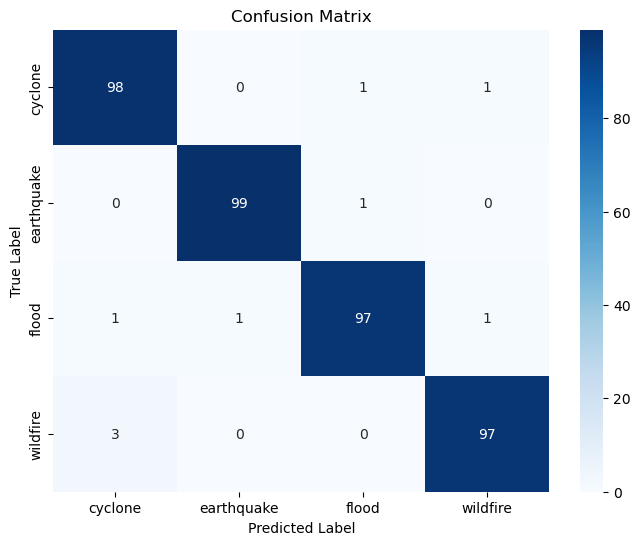

In [14]:
"""
Compute confusion matrix to show where mistakes happened during validation.
"""
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


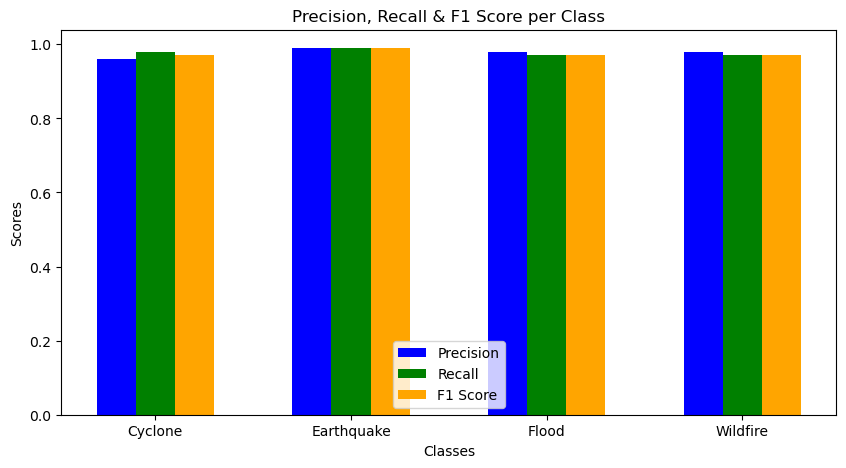

In [15]:
"""
Compute a bar chart to show the evaluation metrics for each class.
"""
class_labels = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']

# Precision, Recall, F1 scores (from classification report)
precision = [0.96, 0.99, 0.98, 0.98]
recall = [0.98, 0.99, 0.97, 0.97]
f1_score = [0.97, 0.99, 0.97, 0.97]

x = np.arange(len(class_labels))  # Label locations
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(10, 5))

# Create bars for precision, recall, and F1-score
ax.bar(x - width, precision, width, label='Precision', color='blue')
ax.bar(x, recall, width, label='Recall', color='green')
ax.bar(x + width, f1_score, width, label='F1 Score', color='orange')

# Labels & Title
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall & F1 Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()

plt.show()

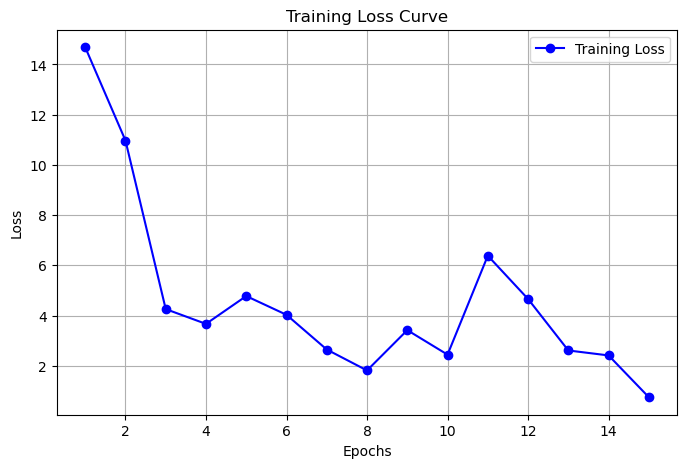

In [16]:
def plot_loss_curve(loss_values):
    """
    Plot the loss of the model.
    """
    num_epochs = len(loss_values)
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
loss_values = train_loss
plot_loss_curve(loss_values)
